### Import Necessary Library

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import nltk
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from sklearn import metrics
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.layers import Input, Conv1D, Concatenate, MaxPooling1D, Dense, Flatten, Embedding, LSTM, SpatialDropout1D, Dropout, MaxPooling2D, Bidirectional
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax

### Load Data

In [3]:
# load the data
data = pd.read_csv("/content/train.csv")
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
# print info of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


### Preprocessing

#### Dropping Null Values

In [5]:
# removing Null values
data.dropna(inplace= True)

print("No of training data:", data.shape[0])
data.info()

No of training data: 27480
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


#### Checking Data Imbalance

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64 

No of training examples: 27480


<BarContainer object of 3 artists>

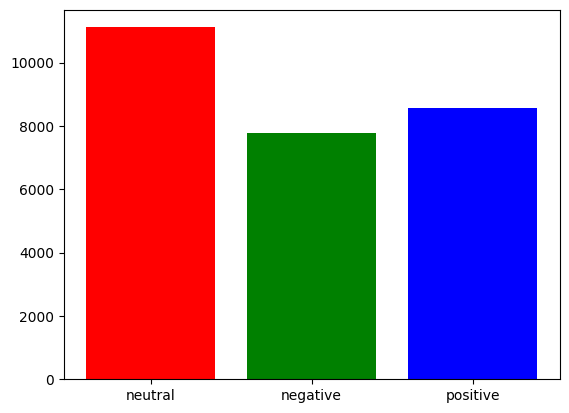

In [9]:
print(data['sentiment'].value_counts(), "\n")
print("No of training examples:", data.shape[0])

# plot class distribution
sentiments = []
sentiment_count = []
for i in data.sentiment.unique():
    sentiments.append(i)
    sentiment_count.append(data.sentiment[data.sentiment==i].count())
plt.bar(sentiments, sentiment_count, color = ["r", "g", "b"])

Neutral classes are more than the Positive and Negative classes. There is no major imbalance in the dataset

#### Encode the classes

Negative classes are set to the 0, neutral classes set as 1 and positive classes set as 2

In [10]:
data["sentiment"].replace("neutral", 1, inplace = True)
data["sentiment"].replace("positive", 2, inplace = True)
data["sentiment"].replace("negative", 0, inplace = True)
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0
2,088c60f138,my boss is bullying me...,bullying me,0
3,9642c003ef,what interview! leave me alone,leave me alone,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0


#### Text - Preprocess

Created a decontracted function which replace short hand word into there actual parts



In [11]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [14]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
            'won', "won't", 'wouldn', "wouldn't"]

from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    for sentence in tqdm(text_data):
        sent = decontracted(sentence)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

X_processed = preprocess_text(data['text'])

100%|██████████| 27480/27480 [00:02<00:00, 10458.89it/s]


Add the preprocesses text into the data a new column

In [15]:
data['preprocessed_text'] = X_processed
data.head(5)

,textID,text,selected_text,sentiment,preprocessed_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",1,responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,0,boss bullying
3,9642c003ef,what interview! leave me alone,leave me alone,0,interview leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0,sons put releases already bought


Removing the text data having sequences less than 4

In [16]:
# removing sentences of length less than 4
data_processed = data[data['preprocessed_text'].str.len()>3]
print('The shape of data :', data_processed.shape)

X = data_processed["preprocessed_text"]
Y = data_processed["sentiment"]

print('No. of datapoints in X', len(X))
print('No of labels in Y', len(X))

The shape of data : (27297, 5)
No. of datapoints in X 27297
No of labels in Y 27297


Selecting maximum sequences lenght and remove the text having length greater than that maximum sequence

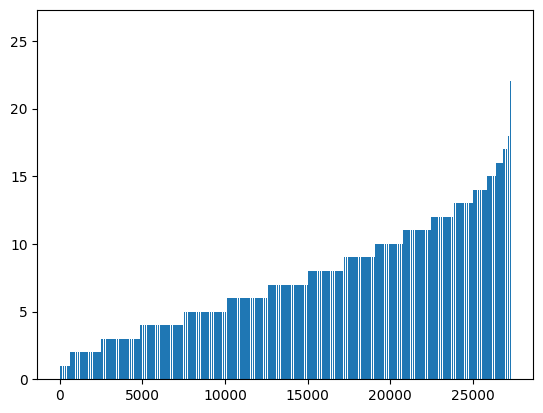

In [18]:
# plot doc word length
sent_len = X.apply(lambda x:len(str(x).split(' ')))
plt.bar(range(27297), sent_len.sort_values().values)
plt.show()

In [19]:
for i in range(1, 50):
    print(f"{95+i/10}th percentile length: ", np.percentile(sent_len.sort_values().values, 95+i/10))

95.1th percentile length:  15.0
95.2th percentile length:  15.0
95.3th percentile length:  15.0
95.4th percentile length:  15.0
95.5th percentile length:  15.0
95.6th percentile length:  15.0
95.7th percentile length:  15.0
95.8th percentile length:  15.0
95.9th percentile length:  15.0
96.0th percentile length:  15.0
96.1th percentile length:  15.0
96.2th percentile length:  15.0
96.3th percentile length:  15.0
96.4th percentile length:  15.0
96.5th percentile length:  15.0
96.6th percentile length:  15.0
96.7th percentile length:  15.0
96.8th percentile length:  15.0
96.9th percentile length:  16.0
97.0th percentile length:  16.0
97.1th percentile length:  16.0
97.2th percentile length:  16.0
97.3th percentile length:  16.0
97.4th percentile length:  16.0
97.5th percentile length:  16.0
97.6th percentile length:  16.0
97.7th percentile length:  16.0
97.8th percentile length:  16.0
97.9th percentile length:  16.0
98.0th percentile length:  16.0
98.1th percentile length:  16.0
98.2th p

So here I am taking 20 as the maximum sequence length and truncate all the sequences greater than it.

### Tokenization and padding

In [20]:
# tokenize and pad senences
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(X.values)

X = t.texts_to_sequences(data_processed['preprocessed_text'])    # sequence of words for each sentence according to their preference in dictationary
X = pad_sequences(X, maxlen = 20)
print(X)

[[    0     0     0 ...     0 10254    12]
 [    0     0     0 ...    37  1338  2173]
 [    0     0     0 ...     0  1240 10255]
 ...
 [    0     0     0 ...   539   752  2720]
 [    0     0     0 ...     0     0   581]
 [    0     0     0 ...  2174   143   550]]


In [21]:
# one hot encoding labels
Y = to_categorical(Y, num_classes = 3)
Y.shape

(27297, 3)

In [22]:
enbadding_dims = 128
lstm_out = 300

vocab_size = len(t.word_index) + 1
print('Vacubalary size: ', vocab_size)

Vacubalary size:  25783


### LSTM Model + Keras Embedding

#### Architechture

In [27]:
model = Sequential()
model.add(Embedding(vocab_size, enbadding_dims,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2, return_sequences = True))
model.add(LSTM(400, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(3,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 128)           3300224   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 20, 128)           0         
 alDropout1D)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 20, 300)           514800    
                                                                 
 lstm_3 (LSTM)               (None, 400)               1121600   
                                                                 
 dense (Dense)               (None, 32)                12832     
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                      

#### Fitting the model

In [28]:
batch_size = 32
H = model.fit(X, Y, epochs = 4, batch_size = batch_size, verbose = 1, validation_split = 0.2)

Epoch 1/4
683/683 [==============================] - 524s 753ms/step - loss: 0.8401 - accuracy: 0.6086 - val_loss: 0.6991 - val_accuracy: 0.7223
Epoch 2/4
683/683 [==============================] - 548s 801ms/step - loss: 0.5929 - accuracy: 0.7587 - val_loss: 0.6823 - val_accuracy: 0.7212
Epoch 3/4
683/683 [==============================] - 502s 736ms/step - loss: 0.4390 - accuracy: 0.8294 - val_loss: 0.7313 - val_accuracy: 0.7057
Epoch 4/4
683/683 [==============================] - 468s 686ms/step - loss: 0.3410 - accuracy: 0.8702 - val_loss: 0.8374 - val_accuracy: 0.7046


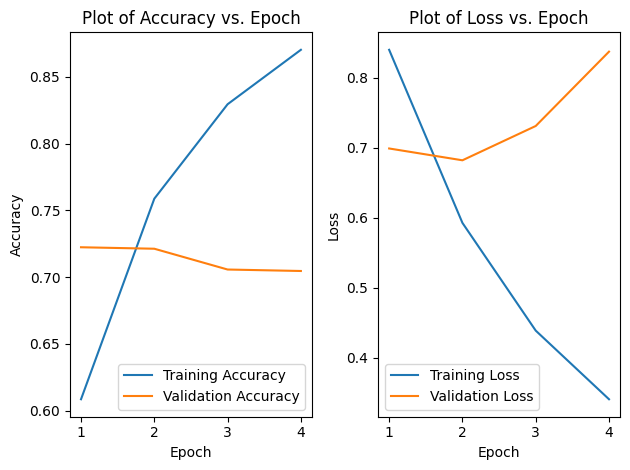

In [30]:
import matplotlib.pyplot as plt

# Plot of accuracy vs. epoch
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(range(1, 5), H.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, 5), H.history['val_accuracy'], label='Validation Accuracy')
plt.title('Plot of Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot of loss vs. epoch
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(range(1, 5), H.history['loss'], label='Training Loss')
plt.plot(range(1, 5), H.history['val_loss'], label='Validation Loss')
plt.title('Plot of Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


#### Testing the Model

In [32]:
test_data = pd.read_csv("test.csv")
test_data.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [33]:
# Preprocessing data
test_text = test_data["text"]
preprocessed_test_data = preprocess_text(test_text)
test_data['preprocessed_text'] = preprocessed_test_data
# Tokenize the sequence
X_test = t.texts_to_sequences(test_data['preprocessed_text'])
# Pad the sequence
X_test = pad_sequences(X_test, maxlen = 20)
X_test

100%|██████████| 3534/3534 [00:00<00:00, 4521.00it/s]


array([[    0,     0,     0, ...,     8,    74,    22],
       [    0,     0,     0, ...,  1595,  2125,  4178],
       [    0,     0,     0, ...,  1395,   728,   702],
       ...,
       [    0,     0,     0, ...,   448, 10986,  8057],
       [    0,     0,     0, ...,    58,    10,   906],
       [    0,     0,     0, ...,   273,  2396,  3360]], dtype=int32)

In [34]:
# Preprocess (Encode) the output column
test_label = test_data["sentiment"]
test_data["sentiment"].replace("negative", 0, inplace = True)
test_data["sentiment"].replace("positive", 2, inplace = True)
test_data["sentiment"].replace("neutral", 1, inplace = True)
test_data.head()

,textID,text,sentiment,preprocessed_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,1,last session day http twitpic com 67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,2,shanghai also really exciting precisely skyscr...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",0,recession hit veronique branquinho quit compan...
3,01082688c6,happy bday!,2,happy bday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,2,http twitpic com 4w75p like


In [35]:
test_label = test_data["sentiment"]
Y_test = to_categorical(test_label)

In [36]:
model.evaluate(X_test, Y_test, verbose = 2, batch_size = 64)

56/56 - 10s - loss: 0.8344 - accuracy: 0.7006 - 10s/epoch - 172ms/step


[0.8344160914421082, 0.7006224989891052]

The validation accuracy is 70.06 percent on the test  set

### LSTM Model + Glove Embedding

In [37]:
# downloading the glove word embedding
!wget "http://nlp.stanford.edu/data/glove.840B.300d.zip"

--2023-11-23 20:33:21--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2023-11-23 20:33:22--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2023-11-23 20:33:22--  https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/

In [40]:
# unzip glove embedding
! unzip "./glove.840B.300d.zip"

Archive:  ./glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [41]:
# generate word embedding dictationary
embeddings_index = {}
f = open('./glove.840B.300d.txt')
print('Loading glove vetors...')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded!!!')


Loading glove vetors...
GloVe data loaded!!!


In [42]:
# save the word embedding dictationary
import pickle
with open('embeddings_glove.pickle', 'wb') as handle:
    pickle.dump(embeddings_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
# making embedding weight metrix by glove vectors
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [46]:
# input layer
inputs = tf.keras.Input(shape=(20))

# embedding layer with pretrained weight
embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(inputs)
lstm1 = LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2, return_sequences = True)(embedding)
lstm2 = LSTM(400, dropout=0.2, recurrent_dropout=0.2)(lstm1)
dense1 = Dense(32, activation = "relu")(lstm2)
dense2 = Dense(64, activation = "relu")(dense1)
out = Dense(3,activation='sigmoid')(dense2)

# build the model
model = Model(inputs=inputs, outputs=out)

In [47]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 20, 300)           7734900   
                                                                 
 lstm_4 (LSTM)               (None, 20, 300)           721200    
                                                                 
 lstm_5 (LSTM)               (None, 400)               1121600   
                                                                 
 dense_3 (Dense)             (None, 32)                12832     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 3)                 195   

In [48]:
H1 = model.fit(X, Y, epochs = 6, batch_size=batch_size, verbose = 1, validation_split = 0.2)

Epoch 1/6
683/683 [==============================] - 492s 708ms/step - loss: 0.7425 - accuracy: 0.6783 - val_loss: 0.6722 - val_accuracy: 0.7302
Epoch 2/6
683/683 [==============================] - 480s 703ms/step - loss: 0.6312 - accuracy: 0.7431 - val_loss: 0.6303 - val_accuracy: 0.7399
Epoch 3/6
683/683 [==============================] - 478s 700ms/step - loss: 0.5921 - accuracy: 0.7605 - val_loss: 0.6223 - val_accuracy: 0.7505
Epoch 4/6
683/683 [==============================] - 480s 703ms/step - loss: 0.5548 - accuracy: 0.7753 - val_loss: 0.6155 - val_accuracy: 0.7553
Epoch 5/6
683/683 [==============================] - 479s 701ms/step - loss: 0.5074 - accuracy: 0.7962 - val_loss: 0.6280 - val_accuracy: 0.7487
Epoch 6/6
683/683 [==============================] - 479s 702ms/step - loss: 0.4505 - accuracy: 0.8205 - val_loss: 0.6705 - val_accuracy: 0.7485


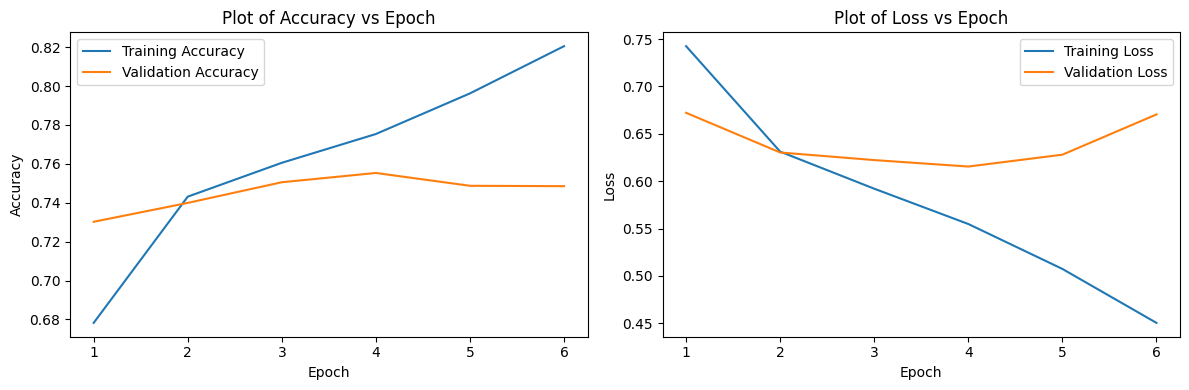

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy
axes[0].plot(range(1, 7), H1.history['accuracy'], label='Training Accuracy')
axes[0].plot(range(1, 7), H1.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Plot of Accuracy vs Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot loss
axes[1].plot(range(1, 7), H1.history['loss'], label='Training Loss')
axes[1].plot(range(1, 7), H1.history['val_loss'], label='Validation Loss')
axes[1].set_title('Plot of Loss vs Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

In [51]:
model.evaluate(X_test, Y_test, verbose = 2, batch_size = 64)

56/56 - 10s - loss: 0.6508 - accuracy: 0.7583 - 10s/epoch - 186ms/step


[0.6508498191833496, 0.7583475112915039]

Accuracy obtrained is 75.83

### CNN Model + Glove Embedding

In [52]:
# input layer
inputs = tf.keras.Input(shape=(20))

# embedding layer with pretrained weight
embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(inputs)

# parellel convolution_block_1
conv1_1 = Conv1D(16, 3, activation=tf.nn.relu, padding = 'same')(embedding)
conv1_2 = Conv1D(16, 2, activation=tf.nn.relu, padding = 'same')(embedding)
conv1_3 = Conv1D(16, 5, activation=tf.nn.relu, padding = 'same')(embedding)

# concatenate_1
concat_1 = Concatenate(axis = 1)([conv1_1, conv1_2, conv1_3])
concat_1 = MaxPooling1D(2)(concat_1)

# parellel convolution_block_2
conv2_1 = Conv1D(24, 7, activation=tf.nn.relu, padding = 'same')(concat_1)
conv2_2 = Conv1D(24, 9, activation=tf.nn.relu, padding = 'same')(concat_1)
conv2_3 = Conv1D(24, 5, activation=tf.nn.relu, padding = 'same')(concat_1)

# concatenate_2
concat_2 = Concatenate(axis = 1)([conv2_1, conv2_2, conv2_3])
# concat_2 = MaxPooling1D(2, stride = 1)(concat_2)

# convolutiona layer
conv3 = Conv1D(10, 115, activation=tf.nn.relu, padding = 'same')(concat_2)

# flatten layer
flat = Flatten()(conv3)
# dropout layer
drop = Dropout(0.3)(flat)

# dense layers
dense_1 = Dense(256, activation=tf.nn.relu)(drop)
drop = Dropout(0.25)(dense_1)
dense_1 = Dense(100, activation=tf.nn.relu)(dense_1)

# output layer with 20 output nurons
outputs = Dense(3, activation=tf.nn.softmax)(dense_1)

# build the model
model = Model(inputs=inputs, outputs=outputs)

In [53]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 20, 300)              7734900   ['input_2[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 20, 16)               14416     ['embedding_3[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)           (None, 20, 16)               9616      ['embedding_3[0][0]']         
                                                                                            

In [54]:
# compile the model
model.compile(optimizer=Adam(learning_rate = 0.0005), loss='categorical_crossentropy', metrics = ['accuracy'])

In [55]:
H = model.fit(X, Y, epochs = 4, batch_size=batch_size, verbose = 1, validation_split = 0.2)

Epoch 1/4
683/683 [==============================] - 52s 73ms/step - loss: 0.7865 - accuracy: 0.6424 - val_loss: 0.6622 - val_accuracy: 0.7214
Epoch 2/4
683/683 [==============================] - 54s 78ms/step - loss: 0.6317 - accuracy: 0.7420 - val_loss: 0.6528 - val_accuracy: 0.7260
Epoch 3/4
683/683 [==============================] - 49s 72ms/step - loss: 0.5637 - accuracy: 0.7692 - val_loss: 0.6825 - val_accuracy: 0.7339
Epoch 4/4
683/683 [==============================] - 52s 76ms/step - loss: 0.4849 - accuracy: 0.8113 - val_loss: 0.6861 - val_accuracy: 0.7222


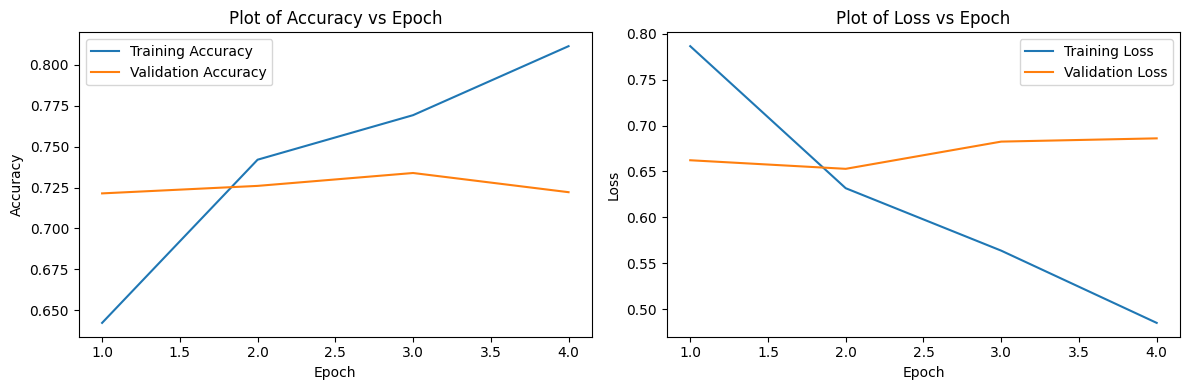

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy
axes[0].plot(range(1, 5), H.history['accuracy'], label='Training Accuracy')
axes[0].plot(range(1, 5), H.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Plot of Accuracy vs Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot loss
axes[1].plot(range(1, 5), H.history['loss'], label='Training Loss')
axes[1].plot(range(1, 5), H.history['val_loss'], label='Validation Loss')
axes[1].set_title('Plot of Loss vs Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

In [58]:
model.evaluate(X_test, Y_test, verbose = 2, batch_size = 64)

56/56 - 3s - loss: 0.6778 - accuracy: 0.7241 - 3s/epoch - 54ms/step


[0.6778451204299927, 0.7241086363792419]

The Accuracy obtained is 72.41 %